In [133]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import spacy
import re
import spacy.lang.ru
from spacy.lang.ru.stop_words import STOP_WORDS
from spacy.cli import download
import nltk
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import WordNetLemmatizer
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import pymorphy2
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
import transformers
from transformers import BertModel
from transformers.models.bert.tokenization_bert import BertTokenizer
from pathlib import Path
import torch

2023-04-09 11:22:44.290909: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64
2023-04-09 11:22:44.290943: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-09 11:22:44.290964: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (s-c73e44f6-a48c-4ed3-aa95-17cd95e777bd): /proc/driver/nvidia/version does not exist


In [38]:
#!g2.2
#%pip install seaborn

In [39]:
#%pip install https://github.com/explosion/spacy-models/releases/download/ru_core_news_sm-3.5.0/ru_core_news_sm-3.5.0-py3-none-any.whl

ПРЕДОБРАБОТКА ДАННЫХ

In [41]:
df = pd.read_csv('/home/jupyter/mnt/s3/hsedatafitpredict1392/train.csv', index_col=0)
df

,sentence,1category,2category,sentiment
4754,При этом всегда получал качественные услуги.,Communication,NaN,+
4417,"Не вижу, за что хотя бы 2 поставить, сервис на 1!",?,NaN,−
3629,"Вот так ""Мой любимый"" банк МКБ меня обманул.",?,NaN,−
11640,Отвратительное отношение к клиентам.,Communication,NaN,−
5571,"Всегда в любое время дня и ночи помогут, ответ...",Communication,NaN,+
...,...,...,...,...
8004,Никогда и ни в коем случае не открывайте счет ...,Communication,NaN,−
18182,ТИ откровенно забили на качество и развивают с...,Quality,NaN,−
744,"Я считаю, это прорыв и лидерство финансовых ус...",?,NaN,+
6220,"Писал мужчина очень доходчиво, не финансовым я...",Communication,NaN,+


In [74]:
def dis(dataframe):
    display(dataframe.shape, dataframe.head(4), dataframe.tail(4))
    return None

# функция для нужного нам округления с трешхолдом
def my_round(x, tr_hold=0.5):
    if x >= tr_hold:
        return 1
    if x <= -tr_hold:
        return -1
    return 0

#TF_IDF + lemmatization
def punctuation(line):
    return re.sub(r'[.,!?\'\"]', '', line)

def removing_stopwords(line):
    text_tokens = word_tokenize(line)
    remove_sw = [word for word in text_tokens if not word in stopwords.words()]
    res = ''
    for i in range(len(remove_sw)):
        res += ''.join(remove_sw[i]) + ' '
    return res[:-1]

def extract_keywords(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([i for i in text if not i.isdigit()])
    text = ' '.join(text.strip().split())
    doc = nlp(text)
    stop_words = spacy.lang.ru.stop_words.STOP_WORDS
    date_names = set(['январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь',
                  'понедельник', 'вторник', 'среда', 'четверг', 'пятница', 'суббота', 'воскресенье'])
    for word in date_names:
        stop_words.add(word.lower())
    lemmas = [token.lemma_ for token in doc if ((not token.is_stop) and token.lemma_ not in stop_words)]
    lemmi = list(set(lemmas))
    res =''
    for i in range(0, len(lemmi)):
        res += ''.join(lemmi[i]) + ' '
    return res[:-1]

# функция для удаления знаков препинания
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

morph = pymorphy2.MorphAnalyzer()
def lemmatization(line):
    text_tokens = word_tokenize(line)
    remove_sw = [word for word in text_tokens if not word in stopwords.words()]
    res = ''
    for i in range(0, len(remove_sw)):
        elem = morph.parse(remove_sw[i])[0][2]
        res += ''.join(elem) + ' '
    return res[:-1]

In [51]:
def extract_keywords(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([i for i in text if not i.isdigit()])
    doc = nlp(text)
    stop_words = spacy.lang.ru.stop_words.STOP_WORDS
    lemmas = [token.lemma_ for token in doc if not token.is_stop]
    return list(set(lemmas))

In [44]:
#!c1.32
# кодируем таргет (sentiment)
df.sentiment = df.sentiment.apply(lambda x: 1 if x == "+" else (0 if x == "?" else -1))

# меняем значения пропусков в категорях на удобные
df['1category'].replace('?', 'not def', inplace=True)
df['2category'].fillna('-', inplace=True)
dis(df)

(19361, 4)

,sentence,1category,2category,sentiment
4754,При этом всегда получал качественные услуги.,Communication,-,1
4417,"Не вижу, за что хотя бы 2 поставить, сервис на 1!",not def,-,-1
3629,"Вот так ""Мой любимый"" банк МКБ меня обманул.",not def,-,-1
11640,Отвратительное отношение к клиентам.,Communication,-,-1


,sentence,1category,2category,sentiment
18182,ТИ откровенно забили на качество и развивают с...,Quality,-,-1
744,"Я считаю, это прорыв и лидерство финансовых ус...",not def,-,1
6220,"Писал мужчина очень доходчиво, не финансовым я...",Communication,-,1
8433,"Данная ситуация меня сильно выбила из колеи, и...",Communication,-,-1


In [45]:
#!c1.32
# приводим dataframe к более удобному виду с одним полем категорий
df_big = pd.concat([df[['sentence', '1category', 'sentiment']].rename(columns={'1category':'category'}),
                    df[df['2category'] != '-'][['sentence', '2category', 'sentiment']].rename(columns={'2category':'category'})])
df_big.reset_index(drop=True, inplace=True)
dis(df_big)

(20360, 3)

,sentence,category,sentiment
0,При этом всегда получал качественные услуги.,Communication,1
1,"Не вижу, за что хотя бы 2 поставить, сервис на 1!",not def,-1
2,"Вот так ""Мой любимый"" банк МКБ меня обманул.",not def,-1
3,Отвратительное отношение к клиентам.,Communication,-1


,sentence,category,sentiment
20356,Это реально круто.2) Очень грамотные менеджеры...,Communication,1
20357,"Ответа Банка я так и не получила, и, хуже того...",Safety,-1
20358,* Удобство: 10 из 10* Работа сотрудников: 10 и...,Quality,1
20359,Первое знакомство с новым для меня банком прош...,Communication,1


In [46]:
#!c1.32
# кодируем категорию используя OneHotEncoder
oenc =  OneHotEncoder(handle_unknown='ignore')
che_status_enc = oenc.fit_transform(df_big[['category']])

che_status_enc = che_status_enc.toarray() # converting to numpy array
che_status_enc=pd.DataFrame(che_status_enc) # converting to dataframe
che_status_enc=che_status_enc.add_prefix('checking_status')

df_big_ohne = pd.concat([df_big,che_status_enc],axis=1)
df_big_new = df_big_ohne[['sentence', 'checking_status0',
                          'checking_status1', 'checking_status2', 
                          'checking_status3', 'checking_status4', 
                          'sentiment']]
df_big_new.columns = ['sentence', 'communication',
                      'price', 'quality', 'safety',
                      'not_def', 'sentiment',
                     ]

dis(df_big_new)

(20360, 7)

,sentence,communication,price,quality,safety,not_def,sentiment
0,При этом всегда получал качественные услуги.,1.0,0.0,0.0,0.0,0.0,1
1,"Не вижу, за что хотя бы 2 поставить, сервис на 1!",0.0,0.0,0.0,0.0,1.0,-1
2,"Вот так ""Мой любимый"" банк МКБ меня обманул.",0.0,0.0,0.0,0.0,1.0,-1
3,Отвратительное отношение к клиентам.,1.0,0.0,0.0,0.0,0.0,-1


,sentence,communication,price,quality,safety,not_def,sentiment
20356,Это реально круто.2) Очень грамотные менеджеры...,1.0,0.0,0.0,0.0,0.0,1
20357,"Ответа Банка я так и не получила, и, хуже того...",0.0,0.0,0.0,1.0,0.0,-1
20358,* Удобство: 10 из 10* Работа сотрудников: 10 и...,0.0,0.0,1.0,0.0,0.0,1
20359,Первое знакомство с новым для меня банком прош...,1.0,0.0,0.0,0.0,0.0,1


In [47]:
#!c1.32
# Создаем плоский dateframe для более удобной оценки категорий
df_final = df_big_new.groupby(['sentence']).agg({'communication':'sum',
                                                 'price':'sum',
                                                 'quality':'sum',
                                                 'safety':'sum',
                                                 'not_def':'sum',
                                                 'sentiment':'mean',
                                                })
dis(df_final)

(7166, 6)

,communication,price,quality,safety,not_def,sentiment
sentence,,,,,,
"10.12.2020 20:57 Хотелось бы выразить огромную благодарность банку Тинькофф за отличные дебетовые карты,а именно Тинькофф Блэк и Тинькофф Джуниор.",0.0,0.0,3.0,0.0,0.0,1.000000
"!, на что сотрудник банка ответила мне что данную отметку мне ставить почему-то нельзя.",1.0,0.0,0.0,0.0,2.0,-0.666667
"!, тем самым оставив меня без средств к существованию, тем более я многодетный отец, единственный кормилец семьи!!!",0.0,0.0,1.0,0.0,2.0,-1.000000
"!16 ноября сего года я обращаюсь к администратору энергомаша, нет сил и нервов уже!",0.0,0.0,0.0,0.0,3.0,-0.333333


,communication,price,quality,safety,not_def,sentiment
sentence,,,,,,
я у сотрудника спросила- получила ответ. но сотрудник меня обманул наглым образом.,3.0,0.0,0.0,1.0,0.0,-1.0
"– восхищаюсь я. Проходит еще неделя... Ну, я думаю, интересно, а то ближайшее время уже наступило или нет... Звоню на Горячую линию 8 800 555 5550, все ж под рукой – Интернет, телефон… По телефону сразу предупреждают – запись разговора обязательна – собираюсь с мыслями, чтобы меня поняли.– Слушаю вас, – протяжное московское аканье.",2.0,0.0,0.0,0.0,1.0,0.0
"…Вы своих клиентов совсем не уважаете, считая их идиотами и делая такие предложения о рефинансировании?",2.0,1.0,1.0,0.0,0.0,-1.0
№ ДО 53/Ф20-04-07/1333 от 19.09.2018 и также в тот же день через личный кабинет на получение закладной № 78907101117631.,0.0,0.0,0.0,0.0,3.0,0.0


In [48]:
#!c1.32
# добавляем возвращаем классический sentiment
df_final['y'] = df_final.sentiment.apply(my_round)
df_final_ = pd.DataFrame(df_final).reset_index()

dis(df_final_)

(7166, 8)

,sentence,communication,price,quality,safety,not_def,sentiment,y
0,10.12.2020 20:57 Хотелось бы выразить огромну...,0.0,0.0,3.0,0.0,0.0,1.000000,1
1,"!, на что сотрудник банка ответила мне что дан...",1.0,0.0,0.0,0.0,2.0,-0.666667,-1
2,"!, тем самым оставив меня без средств к сущест...",0.0,0.0,1.0,0.0,2.0,-1.000000,-1
3,!16 ноября сего года я обращаюсь к администрат...,0.0,0.0,0.0,0.0,3.0,-0.333333,0


,sentence,communication,price,quality,safety,not_def,sentiment,y
7162,я у сотрудника спросила- получила ответ. но со...,3.0,0.0,0.0,1.0,0.0,-1.0,-1
7163,"– восхищаюсь я. Проходит еще неделя... Ну, я д...",2.0,0.0,0.0,0.0,1.0,0.0,0
7164,"…Вы своих клиентов совсем не уважаете, считая ...",2.0,1.0,1.0,0.0,0.0,-1.0,-1
7165,№ ДО 53/Ф20-04-07/1333 от 19.09.2018 и также в...,0.0,0.0,0.0,0.0,3.0,0.0,0


In [17]:
#!c1.32
# сохраняем в parquet
#df_final_.to_parquet('/home/jupyter/mnt/s3/hsedatafitpredict1392/mega_train.parquet')
#df_final_.to_csv('/home/jupyter/mnt/s3/hsedatafitpredict1392/mega_train.csv')

Обработка первичных данных, подготовка данных для моделей на классическом ML

In [151]:
#!c1.32
df_final_['without_punct'] = df_final_['sentence'].apply(punctuation)

In [152]:
#!c1.32
df_final_['without_stopwords'] = df_final_['without_punct'].apply(removing_stopwords)

In [153]:
#!c1.32
df_final_['lemmatized'] = df_final_['without_stopwords'].apply(lemmatization)

In [154]:
#!c1.32
df_final_['y_lemma'] = df_final_['lemmatized'].replace('№', '', regex=True)
df_final_['y_lemma'] = df_final_['y_lemma'].replace('', '', regex=True)
df_final_['y_lemma'] = df_final_['y_lemma'].apply(remove_punctuation)

In [146]:
#!c1.32
df_final_['y_lemma'] = df_final_['y_lemma'].replace('[^0-9]+', '', regex=True)

In [155]:
#!c1.32
df_final_

,sentence,communication,price,quality,safety,not_def,sentiment,y,without_punct,without_stopwords,lemmatized,y_lemma
0,10.12.2020 20:57 Хотелось бы выразить огромну...,0.0,0.0,3.0,0.0,0.0,1.000000,1,10122020 20:57 Хотелось бы выразить огромную ...,10122020 20:57 Хотелось выразить огромную благ...,10122020 20:57 хотеться выразить огромный благ...,10122020 2057 хотеться выразить огромный благо...
1,"!, на что сотрудник банка ответила мне что дан...",1.0,0.0,0.0,0.0,2.0,-0.666667,-1,на что сотрудник банка ответила мне что данну...,сотрудник банка ответила данную отметку ставит...,сотрудник банк ответить данный отметка ставить...,сотрудник банк ответить данный отметка ставить...
2,"!, тем самым оставив меня без средств к сущест...",0.0,0.0,1.0,0.0,2.0,-1.000000,-1,тем самым оставив меня без средств к существо...,самым оставив средств существованию многодетны...,самый оставить средство существование многодет...,самый оставить средство существование многодет...
3,!16 ноября сего года я обращаюсь к администрат...,0.0,0.0,0.0,0.0,3.0,-0.333333,0,16 ноября сего года я обращаюсь к администрато...,16 ноября сего года обращаюсь администратору э...,16 ноябрь сие год обращаться администратор эне...,16 ноябрь сие год обращаться администратор эне...
4,!22.02.2020 заблокировали счет якобы из-за про...,3.0,0.0,0.0,0.0,0.0,-1.000000,-1,22022020 заблокировали счет якобы из-за просро...,22022020 заблокировали счет якобы из-за просро...,22022020 заблокировать счёт якобы из-за просро...,22022020 заблокировать счёт якобы изза просроч...
...,...,...,...,...,...,...,...,...,...,...,...,...
7161,я своевременно и в полном объеме исполнял ВСЕ ...,0.0,0.0,0.0,0.0,2.0,0.000000,0,я своевременно и в полном объеме исполнял ВСЕ ...,своевременно полном объеме исполнял ВСЕ услови...,своевременно полный объём исполнять всё услови...,своевременно полный объём исполнять всё услови...
7162,я у сотрудника спросила- получила ответ. но со...,3.0,0.0,0.0,1.0,0.0,-1.000000,-1,я у сотрудника спросила- получила ответ но сот...,сотрудника спросила- получила ответ сотрудник ...,сотрудник спросила- получить ответ сотрудник о...,сотрудник спросила получить ответ сотрудник об...
7163,"– восхищаюсь я. Проходит еще неделя... Ну, я д...",2.0,0.0,0.0,0.0,1.0,0.000000,0,– восхищаюсь я Проходит еще неделя Ну я думаю ...,– восхищаюсь Проходит неделя Ну думаю интересн...,– восхищаться проходить неделя ну думать интер...,восхищаться проходить неделя ну думать интере...
7164,"…Вы своих клиентов совсем не уважаете, считая ...",2.0,1.0,1.0,0.0,0.0,-1.000000,-1,…Вы своих клиентов совсем не уважаете считая и...,…Вы своих клиентов уважаете считая идиотами де...,…вы свой клиент уважать считать идиот делать т...,вы свой клиент уважать считать идиот делать та...


TFiDF

In [156]:
#!c1.32
# Определение корпуса текстов
corpus = df_final_['y_lemma'].tolist()
# Инициализация векторизатора
vectorizer = TfidfVectorizer()

In [157]:
#!c1.32
# Преобразование текстов в векторы TF-IDF
vectors = vectorizer.fit_transform(corpus)

# Получение списка слов в порядке их индексации
words = vectorizer.get_feature_names()

In [158]:
#!c1.32
# Создание DataFrame с векторами TF-IDF
tfidf_df = pd.DataFrame(vectors.toarray(), columns=words)
tfidf_df

,000,0004072013100061,0009122016143283,0009132015035110,000говорить,001,001400,0019,0022212016031976,002222201601965410022016,002222201602515119022016,0022222016029182,00367,01,01021,01032021,01042019,0107нерабочий,010818,01082015,01082018,0126,0132021,02,02042018,020711,02072015,020819,02082014,02082019,02102017,025700,03,03022016,03052017,03092020,0402,04032020,0404,040518,...,юля,юниаструма,юноша,юр,юридически,юридический,юриевич,юрий,юрист,юркомпания,юрлицо,юсвой,юскв,юстиция,явиться,являться,явно,явный,яде,язвить,язык,яйцо,якобы,ям,ямашева,ян,январь,янгель,яндекс,яркий,ярко,яро,ярослав,ярославль,ярость,ярый,ясно,ясный,ячейка,ящик
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.190623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


PCA

In [159]:
#!c1.32
X = np.array(tfidf_df)
pca = PCA(n_components=300)
X_pca = pca.fit_transform(X)

In [144]:
#!c1.32
variance_arr = pca.explained_variance_
variance_arr

array([0.00626687, 0.00531887, 0.00528679, 0.00491017, 0.00425593,
       0.00412216, 0.00375558, 0.00346579, 0.00336125, 0.00327549,
       0.00320865, 0.00308145, 0.00304279, 0.00300322, 0.00293233,
       0.00280251, 0.00275875, 0.00269009, 0.00267003, 0.00264231,
       0.00258526, 0.00251586, 0.00249249, 0.00244351, 0.00239511,
       0.00234281, 0.00232409, 0.00228118, 0.00225111, 0.00223672,
       0.00223032, 0.00219447, 0.00215101, 0.00213653, 0.00210805,
       0.00210211, 0.00208562, 0.0020496 , 0.00202753, 0.00198836,
       0.00196993, 0.0019677 , 0.00193714, 0.00193598, 0.00192498,
       0.00189236, 0.00187468, 0.00187231, 0.00185138, 0.00184995,
       0.00182823, 0.00180201, 0.00179873, 0.00179148, 0.00178294,
       0.00176639, 0.00174177, 0.00172512, 0.00170784, 0.00168411,
       0.00166854, 0.00166234, 0.00165222, 0.00164623, 0.00162722,
       0.00162301, 0.00159718, 0.0015903 , 0.00157933, 0.00155828,
       0.00155195, 0.00153992, 0.00152518, 0.00151778, 0.00151

In [160]:
#!c1.32
df_test = pd.read_csv('/home/jupyter/mnt/s3/hsedatafitpredict1392/tfidf_test.csv', index_col=0)

In [163]:
#!c1.32
df_test

,00,000,0000,000р,00600140,00руб,01,02,0200,0216,03,0352,04,05,0503,056300,06,06105,07,0708,0776,08,0811,09,0981,10,100,1000,10000,100000,100000р,10000р,1000р,1005,101а,10548884,10647745,108,10к,11,...,этому,этот,эту,эффекта,эффективно,юmoney,южной,юл,юлии,юмани,юнистрим,юр,юридический,юридическими,юридического,юрист,юрлицо,явился,являемся,является,являлась,являлся,являюсь,являющимся,являясь,явный,языке,якобы,ян,январе,января,яндекс,яндекса,япфр,яркое,яровое,яровом,ясна,яснить,ячейки
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.155330,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.101332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.116253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.26244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.149388,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.112612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [171]:
#!c1.32
# получаем пересечение множеств столбцов
common_cols = list(set(tfidf_df.columns).intersection(set(df_test.columns)))

In [172]:
#!c1.32
tfidf_df_only_cols = list(set(tfidf_df.columns).difference(set(df_test.columns)))

In [174]:
#!c1.32
df_test_cat = df_test[common_cols]


In [175]:
#!c1.32
df_test_cat = df_test_cat.assign(**{col: np.zeros(len(df_test_cat)) for col in tfidf_df_only_cols})

In [176]:
#!c1.32
df_test_cat

,пб,денежный,компания,банкомат,так,коллектив,ежемесячно,тинькова,цифровой,правильно,переводить,можно,прогресс,техподдержка,продлевать,количество,мастеркард,март,приносить,остаток,ожидание,некуда,зарплата,одновременно,один,жесть,воз,карточный,плюс,гибкий,https,бэк,открыть,указать,чистый,лживый,очередь,положительный,запрос,тб,...,1543,времяпрепровождение,нагий,царь,утвердительно,непрофессиональный,904001912,деливерь,пом,похамски,вр,ахнуть,прощание,финиш,попрать,уверилачтый,заострить,мк,24122019,сломаться,пожилое,чековый,воспоминание,держал,пользовиться,критичный,склеить,domrfru,сказалия,67970,файл,изотиков,конфликтный,месяцдругой,оказывать,популярный,людямкоторое,тронутый,сберонлайн,вобщий
0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.21236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.10573,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [166]:
#!c1.32
len(common_cols)

1792

In [177]:
#!c1.32
X_test = np.array(df_test_cat)
X_test = pca.transform(X_test)

In [178]:
#!c1.32
X_test

array([[-0.04215648, -0.02093155,  0.01527775, ...,  0.00290502,
         0.00026166,  0.00263375],
       [-0.04300603, -0.02070848,  0.01454207, ..., -0.00512053,
         0.00121009,  0.00024415],
       [-0.04170013, -0.02033905,  0.0158174 , ...,  0.00098185,
        -0.00223759, -0.00053493],
       ...,
       [-0.04225769, -0.02011778,  0.01472127, ..., -0.00653974,
         0.00010144,  0.00047699],
       [-0.04283835, -0.02113725,  0.01510371, ...,  0.0074668 ,
        -0.00281279,  0.00416271],
       [-0.04320272, -0.02078507,  0.01476557, ..., -0.01305534,
         0.00474953,  0.00027406]])

In [179]:
#!c1.32
pca_df_test = pd.DataFrame(X_test, columns=variables)

In [180]:
#!c1.32
pca_df_test

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,var40,...,var261,var262,var263,var264,var265,var266,var267,var268,var269,var270,var271,var272,var273,var274,var275,var276,var277,var278,var279,var280,var281,var282,var283,var284,var285,var286,var287,var288,var289,var290,var291,var292,var293,var294,var295,var296,var297,var298,var299,var300
0,-0.042156,-0.020932,0.015278,0.000928,0.008239,-0.017295,0.011795,0.015954,0.008851,0.019149,-0.014007,-0.024964,-0.006771,-0.013179,-0.004252,-0.008201,-0.013709,0.003398,0.004149,-0.009228,0.000264,-0.005866,0.008804,-0.020286,0.011679,0.012303,0.007053,0.001115,-0.002449,-0.000281,0.001499,0.001389,0.003818,0.000518,0.000385,0.006333,-0.009639,-0.006566,0.010740,0.009540,...,0.001402,0.001513,-0.005039,0.002769,-0.000478,-0.003086,0.006917,0.002765,-0.000053,0.000056,0.002646,0.001694,0.001772,0.002498,0.000679,-0.000505,0.000527,-0.002637,-0.000469,-0.003824,-0.000789,0.001938,-0.002634,0.004785,-0.001611,-0.007572,-0.002093,0.002154,-0.001263,-0.003217,-0.001989,0.001457,0.005049,-0.001348,-0.001466,-0.002580,-0.000867,0.002905,0.000262,0.002634
1,-0.043006,-0.020708,0.014542,0.001363,0.007471,-0.019240,0.010537,0.014666,0.008365,0.018313,-0.014414,-0.024172,-0.004657,-0.015142,-0.002428,-0.006744,-0.013965,0.004590,0.002779,-0.010022,0.000445,-0.005818,0.007752,-0.020202,0.012026,0.012670,0.004920,0.000310,-0.002384,-0.000858,0.002451,0.005299,0.005481,-0.002623,-0.002940,0.007593,-0.010455,-0.007641,0.008871,0.006595,...,0.005439,-0.011435,0.003045,0.002739,-0.005151,-0.004815,0.005912,0.009030,-0.000808,-0.005679,0.009147,-0.011124,0.006026,0.008440,0.006769,0.003567,-0.000824,0.000548,-0.000165,-0.011113,0.003124,-0.001914,-0.006130,-0.004561,-0.004516,0.000542,-0.005110,0.000098,0.003011,-0.013037,-0.004333,-0.004561,-0.006456,0.000787,-0.010060,-0.008582,0.007343,-0.005121,0.001210,0.000244
2,-0.041700,-0.020339,0.015817,0.000907,0.006880,-0.017344,0.012687,0.016301,0.009447,0.019512,-0.013465,-0.025176,-0.007291,-0.014280,-0.004277,-0.007458,-0.014609,0.004591,0.002995,-0.009979,0.000954,-0.006901,0.007447,-0.019565,0.010053,0.013546,0.006071,-0.000123,-0.002359,-0.001162,0.001150,0.001914,0.004261,-0.002215,-0.000318,0.007873,-0.010240,-0.007107,0.010142,0.007679,...,0.001265,-0.001942,-0.004636,0.002637,-0.001712,-0.002623,0.001780,-0.000192,-0.000130,0.000505,0.000058,0.001364,-0.000751,0.003532,0.000122,-0.000816,0.000133,-0.002299,0.000065,-0.002264,0.000549,0.004665,-0.004609,0.002790,-0.001488,-0.004461,-0.002235,-0.000672,-0.000987,-0.004695,-0.002717,-0.001306,0.001197,-0.002975,0.001316,-0.001966,-0.000762,0.000982,-0.002238,-0.000535
3,-0.041448,-0.019786,0.015522,0.001321,0.007653,-0.017361,0.013185,0.017362,0.009504,0.020432,-0.014301,-0.024954,-0.005877,-0.015537,-0.002630,-0.007426,-0.014736,0.003891,0.002096,-0.009157,0.001436,-0.006622,0.006849,-0.019166,0.009896,0.012500,0.006500,0.001287,-0.002433,-0.000118,0.000972,0.001868,0.004549,-0.002521,-0.001238,0.006451,-0.010302,-0.007660,0.009712,0.006816,...,-0.000197,-0.000218,-0.006233,-0.001864,-0.000710,-0.003257,-0.000609,-0.001195,-0.001162,-0.001885,0.000477,-0.001699,0.000259,0.002839,-0.003102,-0.001161,-0.000813,-0.001156,0.001191,-0.002485,-0.001078,0.003311,-0.003795,0.003185,-0.000769,-0.003003,-0.002041,-0.000392,-0.000196,-0.002020,-0.000620,-0.001944,0.000312,-0.001116,-0.002487,-0.000963,-0.000858,0.000787,-0.001710,0.003643
4,-0.041000,-0.020106,0.016262,0.001294,0.007090,-0.017499,0.012912,0.016673,0.008819,0.019625,-0.014013,-0.025899,-0.006737,-0.015090,-0.003714,-0.007389,-0.014694,0.004943,0.001626,-0.009382,-0.000015,-0.007100,0.008087,-0.018967,0.010631,0.012947,0.007317,0.000537,-0.001606,-0.000905,0.001440,0.000914,0.003709,-0.003386,-0.001185,0.008257,-0.010113,-0.008117,0.010549,0.007085,...,-0.000320,0.001531,-0.0

In [182]:
#!c1.32
pca_df_test.to_csv('/home/jupyter/mnt/s3/hsedatafitpredict1392/pca_df_test.csv')

In [145]:
#!c1.32
variance_arr.sum()

0.39124733080586227

In [87]:
#!c1.32
variables = [f'var{i}' for i in range(1, 301)]

In [88]:
#!c1.32
# создаем новый датафрейм с новыми признаками
pca_df = pd.DataFrame(X_pca, columns=variables)

In [91]:
#!c1.32
X_train, X_test = train_test_split(X, test_size=0.33, random_state=42)

In [93]:
#!c1.32
X_train.shape

(4801, 9961)

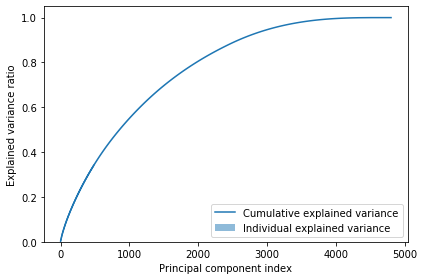

In [92]:
#!c1.32
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
#
# Instantiate PCA
#
pca = PCA()
#
# Determine transformed features
#
X_train_pca = pca.fit_transform(X_train_std)
#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

CATBOOST USING TF_I_DF

In [100]:
#!c1.32
df = pd.read_parquet('/home/jupyter/mnt/s3/hsedatafitpredict1392/mega_train.parquet')

FEATURE ENGINEERING FOR CATBOOST MODEL

In [101]:
#!c1.32
#!c1.32
ot = []

def count_(x):
    digit = 0
    letters = 0
    space = 0
    punctuation = 0
    quotes = 0
    brackets = 0
    money = 0
    other = 0
    exclamation = 0
    question = 0
    smile = 0
    for i in x:
        if i.isalpha():
            letters += 1
        elif i.isnumeric():
            digit += 1
        elif i.isspace():
            space += 1
        elif i in '''“”"'`«»><''':
            quotes += 1
        elif (i in '''….,\n:;–''') or i == '—':
            punctuation += 1
        elif i in '''|[]{}()''':
            brackets += 1
        elif i in '''%~₽&№$=+-*#''':
            money += 1
        elif i in ('🤩', '👍'):
            smile += 1
        elif i in '❗!':
            exclamation +1
        elif i in '?':
            question += 1
        else:
            other += 1
            if i not in ot:
                ot.append(i)
    return [digit, letters, space, quotes, punctuation, brackets, money, smile, exclamation, question, other]

In [102]:
#!c1.32
df['temp'] = df.sentence.apply(lambda x: count_(x))
df.loc[:,'number'] = df.loc[:,'temp'].apply(lambda x: x[0])
df.loc[:,'alpha'] = df.loc[:,'temp'].apply(lambda x: x[1])
df.loc[:,'space'] = df.loc[:,'temp'].apply(lambda x: x[2])
df.loc[:,'quotes'] = df.loc[:,'temp'].apply(lambda x: x[3])
df.loc[:,'punctuation'] = df.loc[:,'temp'].apply(lambda x: x[4])
df.loc[:,'brackets'] = df.loc[:,'temp'].apply(lambda x: x[5])
df.loc[:,'money'] = df.loc[:,'temp'].apply(lambda x: x[6])
df.loc[:,'smile'] = df.loc[:,'temp'].apply(lambda x: x[7])
df['thumb'] = df.sentence.apply(lambda x: x.count('👍'))
df.loc[:,'exclamation'] = df.loc[:,'temp'].apply(lambda x: x[8])
df.loc[:,'question'] = df.loc[:,'temp'].apply(lambda x: x[9])
df.loc[:,'other'] = df.loc[:,'temp'].apply(lambda x: x[-1])

df.drop('temp', axis=1, inplace=True)

In [103]:
#!c1.32
#!c1.32
df['sentence_f'] = df.sentence
def only_char_left(text):
    text_new = ''
    for i in text:
        if i.isalpha() or i == ' ':
            text_new += i
    return text_new
        
    
df['sentence_f'] = df['sentence_f'].apply(lambda x: only_char_left(x))
df['sentence_f'] = df['sentence_f'].apply(lambda x: ' '.join(x.lower().split(' ')))
df['word_qty'] = df['sentence_f'].apply(lambda x: len(x.split()))

In [104]:
#!c1.32
df_filtered = df[['sentence_f', 'word_qty',
                  'number', 'alpha', 'space', 'quotes', 
                  'punctuation', 'exclamation', 'question', 
                  'brackets', 'money', 'smile', 'thumb', 'other',
                  'communication', 'price', 'quality', 'safety', 'y']]



df_filtered.rename(columns={'sentence_f':'sentence',
                            'y': 'sentiment'
                           })
df_filtered

,sentence_f,word_qty,number,alpha,space,quotes,punctuation,exclamation,question,brackets,money,smile,thumb,other,communication,price,quality,safety,y
0,хотелось бы выразить огромную благодарность...,17,12,111,19,0,5,0,0,0,0,0,0,0,0.0,0.0,3.0,0.0,1
1,на что сотрудник банка ответила мне что данну...,13,0,70,13,0,2,0,0,0,1,0,0,0,1.0,0.0,0.0,0.0,-1
2,тем самым оставив меня без средств к существо...,16,0,92,16,0,3,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,-1
3,ноября сего года я обращаюсь к администратору...,13,2,65,13,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0
4,заблокировали счет якобы изза просроченой зад...,27,8,164,27,0,5,0,0,0,1,0,0,0,3.0,0.0,0.0,0.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7161,я своевременно и в полном объеме исполнял все ...,10,0,53,9,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0
7162,я у сотрудника спросила получила ответ но сотр...,12,0,68,11,0,2,0,0,0,1,0,0,0,3.0,0.0,0.0,1.0,-1
7163,восхищаюсь я проходит еще неделя ну я думаю и...,45,11,246,53,0,23,0,0,0,0,0,0,0,2.0,0.0,0.0,0.0,0
7164,вы своих клиентов совсем не уважаете считая их...,15,0,86,14,0,2,0,1,0,0,0,0,0,2.0,1.0,1.0,0.0,-1


In [105]:
#!c1.32
#!c1.32
#df_filtered.to_csv('/home/jupyter/mnt/s3/hsedatafitpredict1392/filtered_train_with_features.csv')

In [109]:
#!c1.32
pca_df.head()

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,var40,...,var261,var262,var263,var264,var265,var266,var267,var268,var269,var270,var271,var272,var273,var274,var275,var276,var277,var278,var279,var280,var281,var282,var283,var284,var285,var286,var287,var288,var289,var290,var291,var292,var293,var294,var295,var296,var297,var298,var299,var300
0,0.028439,0.081455,0.014646,-0.034765,-0.014786,-0.034235,-0.033121,0.035050,-0.044740,0.019742,-0.009341,-0.039441,-0.035073,-0.022526,0.067721,0.030296,-0.067252,0.028260,-0.063153,-0.073253,-0.121551,-0.047244,-0.006342,-0.028665,0.022546,-0.006616,-0.006984,-0.050346,0.016301,0.045454,-0.006752,-0.006332,-0.089153,0.001895,0.027056,-0.048923,-0.025099,0.012333,0.008065,-0.020597,...,-0.014197,0.000792,0.009877,-0.017278,0.007033,0.010467,0.015444,0.004225,-0.051884,-0.001362,-0.000899,-0.013262,-0.010199,-0.013871,0.023080,-0.006764,0.004880,-0.022764,-0.015464,-0.010279,-0.002461,0.026539,-0.035415,0.036604,0.000396,-0.002789,0.008310,0.018142,-0.007006,-0.004252,-0.042157,-0.019614,0.009901,0.004037,0.007926,0.032574,-0.008314,0.020328,-0.006606,-0.005083
1,0.054838,0.082062,-0.054840,-0.061896,-0.128347,0.088274,-0.017486,0.056360,-0.021604,-0.030175,-0.009594,-0.004101,-0.013076,-0.060592,0.004646,-0.013936,0.062077,0.013271,0.027727,-0.010051,0.021830,0.014142,0.007621,-0.056455,-0.026578,0.003065,-0.017748,0.050104,-0.022431,-0.016403,0.006194,0.020893,-0.000127,0.050028,-0.021204,0.012712,-0.044747,-0.042379,0.030784,0.041157,...,0.024204,-0.023082,0.000104,-0.031240,-0.004987,0.021944,-0.000743,-0.026910,-0.003421,0.009609,0.002323,-0.000575,-0.019903,0.006281,-0.030810,0.006705,0.044113,0.024135,-0.003133,0.029371,0.008325,-0.009825,0.018172,-0.031034,-0.017784,0.043157,0.026312,0.020164,0.029125,-0.018340,0.020224,0.007719,0.002239,-0.010167,-0.022861,-0.026369,-0.005086,0.055696,-0.012126,0.018844
2,-0.041202,-0.015547,-0.000728,-0.005007,0.010343,-0.025490,-0.011164,0.004011,0.004463,0.021985,-0.004220,-0.039373,-0.017551,-0.004377,0.002730,-0.019353,-0.035314,0.030323,-0.005991,-0.001145,0.017979,-0.014152,-0.004939,-0.013002,0.029348,0.034919,0.026703,0.000949,0.002685,-0.011839,-0.044297,0.003172,-0.028542,0.008420,0.002917,0.009761,0.013623,-0.017936,-0.002537,0.011582,...,-0.011488,-0.023197,0.004509,0.035383,0.001547,-0.021349,-0.022584,-0.005778,0.001681,0.002643,0.002868,-0.008168,0.001139,0.007534,-0.022088,0.017631,0.017686,0.005414,0.006737,-0.017950,-0.012787,-0.021670,0.038621,0.000469,0.005475,0.013876,0.009926,0.014066,-0.009077,-0.005835,0.006138,0.018452,-0.022911,0.008173,0.020640,-0.000583,0.016367,-0.003005,-0.017283,0.032062
3,-0.036412,-0.011801,-0.011671,-0.004535,0.004314,-0.047550,0.021967,0.018772,0.004618,0.010866,-0.030739,-0.023063,-0.003589,-0.019597,-0.024609,0.000928,-0.014359,-0.032219,-0.009414,-0.024914,0.018474,0.001474,-0.010156,-0.003686,-0.003387,0.043768,0.028097,0.025552,-0.013171,0.009508,-0.011709,0.058133,0.033437,-0.028838,0.006836,-0.023058,0.018015,-0.022197,0.008404,-0.002783,...,0.009031,-0.038618,-0.028491,0.037767,0.048418,0.013987,0.016672,-0.002318,0.026353,-0.005845,-0.035767,0.039022,0.006159,-0.006632,-0.017040,-0.030987,0.006824,0.035109,0.012108,0.029519,-0.003243,0.008466,0.015810,-0.026346,-0.023630,0.000355,0.010804,0.031447,0.021682,0.013338,-0.006839,0.057979,0.043677,-0.040315,0.017470,-0.032624,-0.044541,-0.041933,0.076487,-0.013059
4,-0.052176,-0.020029,-0.048848,-0.030553,-0.001359,-0.029590,0.087486,0.004128,0.014869,-0.005354,-0.043704,0.027403,0.047915,0.026363,0.016505,-0.018411,-0.008277,-0.000015,-0.017025,0.032324,0.001036,0.002406,0.003177,0.003025,0.031943,0.009324,0.013492,-0.047535,0.004308,-0.010313,-0.030779,0.004366,0.022014,0.018428,-0.022436,0.004595,-0.056776,0.017605,-0.074966,0.023270,...,-0.007733,0.005516,0.009552,0.0

In [111]:
#!c1.32
#!c1.32
df_1 = pca_df

In [112]:
#!c1.32
df_big = pd.concat([df_1, df_filtered], axis=1)
# df_big.drop(['sentence', 'communication', 'price', 'quality', 'safety', 'not_def',
#        'sentiment', 'without_punct', 'without_stopwords', 'lemmatized', 'sentence_f'], axis=1, inplace=True)
df_big.drop(['sentence_f'], axis=1, inplace=True)
df_big

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,var40,...,var279,var280,var281,var282,var283,var284,var285,var286,var287,var288,var289,var290,var291,var292,var293,var294,var295,var296,var297,var298,var299,var300,word_qty,number,alpha,space,quotes,punctuation,exclamation,question,brackets,money,smile,thumb,other,communication,price,quality,safety,y
0,0.028439,0.081455,0.014646,-0.034765,-0.014786,-0.034235,-0.033121,0.035050,-0.044740,0.019742,-0.009341,-0.039441,-0.035073,-0.022526,0.067721,0.030296,-0.067252,0.028260,-0.063153,-0.073253,-0.121551,-0.047244,-0.006342,-0.028665,0.022546,-0.006616,-0.006984,-0.050346,0.016301,0.045454,-0.006752,-0.006332,-0.089153,0.001895,0.027056,-0.048923,-0.025099,0.012333,0.008065,-0.020597,...,-0.015464,-0.010279,-0.002461,0.026539,-0.035415,0.036604,0.000396,-0.002789,0.008310,0.018142,-0.007006,-0.004252,-0.042157,-0.019614,0.009901,0.004037,0.007926,0.032574,-0.008314,0.020328,-0.006606,-0.005083,17,12,111,19,0,5,0,0,0,0,0,0,0,0.0,0.0,3.0,0.0,1
1,0.054838,0.082062,-0.054840,-0.061896,-0.128347,0.088274,-0.017486,0.056360,-0.021604,-0.030175,-0.009594,-0.004101,-0.013076,-0.060592,0.004646,-0.013936,0.062077,0.013271,0.027727,-0.010051,0.021830,0.014142,0.007621,-0.056455,-0.026578,0.003065,-0.017748,0.050104,-0.022431,-0.016403,0.006194,0.020893,-0.000127,0.050028,-0.021204,0.012712,-0.044747,-0.042379,0.030784,0.041157,...,-0.003133,0.029371,0.008325,-0.009825,0.018172,-0.031034,-0.017784,0.043157,0.026312,0.020164,0.029125,-0.018340,0.020224,0.007719,0.002239,-0.010167,-0.022861,-0.026369,-0.005086,0.055696,-0.012126,0.018844,13,0,70,13,0,2,0,0,0,1,0,0,0,1.0,0.0,0.0,0.0,-1
2,-0.041202,-0.015547,-0.000728,-0.005007,0.010343,-0.025490,-0.011164,0.004011,0.004463,0.021985,-0.004220,-0.039373,-0.017551,-0.004377,0.002730,-0.019353,-0.035314,0.030323,-0.005991,-0.001145,0.017979,-0.014152,-0.004939,-0.013002,0.029348,0.034919,0.026703,0.000949,0.002685,-0.011839,-0.044297,0.003172,-0.028542,0.008420,0.002917,0.009761,0.013623,-0.017936,-0.002537,0.011582,...,0.006737,-0.017950,-0.012787,-0.021670,0.038621,0.000469,0.005475,0.013876,0.009926,0.014066,-0.009077,-0.005835,0.006138,0.018452,-0.022911,0.008173,0.020640,-0.000583,0.016367,-0.003005,-0.017283,0.032062,16,0,92,16,0,3,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,-1
3,-0.036412,-0.011801,-0.011671,-0.004535,0.004314,-0.047550,0.021967,0.018772,0.004618,0.010866,-0.030739,-0.023063,-0.003589,-0.019597,-0.024609,0.000928,-0.014359,-0.032219,-0.009414,-0.024914,0.018474,0.001474,-0.010156,-0.003686,-0.003387,0.043768,0.028097,0.025552,-0.013171,0.009508,-0.011709,0.058133,0.033437,-0.028838,0.006836,-0.023058,0.018015,-0.022197,0.008404,-0.002783,...,0.012108,0.029519,-0.003243,0.008466,0.015810,-0.026346,-0.023630,0.000355,0.010804,0.031447,0.021682,0.013338,-0.006839,0.057979,0.043677,-0.040315,0.017470,-0.032624,-0.044541,-0.041933,0.076487,-0.013059,13,2,65,13,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0
4,-0.052176,-0.020029,-0.048848,-0.030553,-0.001359,-0.029590,0.087486,0.004128,0.014869,-0.005354,-0.043704,0.027403,0.047915,0.026363,0.016505,-0.018411,-0.008277,-0.000015,-0.017025,0.032324,0.001036,0.002406,0.003177,0.003025,0.031943,0.009324,0.013492,-0.047535,0.004308,-0.010313,-0.030779,0.004366,0.022014,0.018428,-0.022436,0.004595,-0.056776,0.017605,-0.074966,0.023270,...,-0.024487,0.031369,-0.016444,0.020892,-0.039520,0.020847,0.013685,0.012769,-0.009264,-0.055603,-0.060305,0.009353,-0.000584,-0.040149,-0.017703,-0.022526,-0.011906,-0.005864,0.012494,-0.001630,-0.013323,-0.024540,27,8,164,27,0,5,0,0,0,1,0,0,0,3.0,0.0,0.0,0.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [113]:
#!c1.32
df_y = df_big['y'].copy()
df_X = df_big.copy()
df_X.drop('y', axis=1, inplace=True)

In [116]:
#!c1.32
#!c1.32
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold

rf1_2 = CatBoostClassifier(learning_rate=0.055, 
                          n_estimators=1000, 
                          subsample=0.075, 
                          max_depth=5, 
                          verbose=250,
                          l2_leaf_reg = 7,
                          bootstrap_type="Bernoulli",
                          class_weights=[1, 1, 1],
                          loss_function='MultiClass')
#                           eval_metric='F1')

kf = StratifiedKFold(n_splits=7,shuffle=True,random_state=99)
ra = []

for fold,(t_id,v_id) in enumerate(kf.split(df_X,df_y)):
    tx = df_X.iloc[t_id]; ty = df_y.iloc[t_id]
    vx = df_X.iloc[v_id]; vy = df_y.iloc[v_id]
    rf1_2.fit(tx,ty)        
    val_y = rf1_2.predict(vx)
    prob_val_y = rf1_2.predict_proba(vx)

    roc_auc = roc_auc_score(vy, prob_val_y, multi_class='ovr')
    ra.append(roc_auc)
    print('-------------')
    
print(f"Mean roc auc score {np.mean(ra)}")

0:	learn: 1.0822039	total: 70.4ms	remaining: 1m 10s
250:	learn: 0.6057773	total: 2.7s	remaining: 8.06s
500:	learn: 0.4936793	total: 5.22s	remaining: 5.2s
750:	learn: 0.4200444	total: 7.86s	remaining: 2.61s
999:	learn: 0.3665224	total: 10.7s	remaining: 0us
-------------
0:	learn: 1.0868902	total: 20ms	remaining: 20s
250:	learn: 0.5948003	total: 3.19s	remaining: 9.52s
500:	learn: 0.4847017	total: 6.13s	remaining: 6.11s
750:	learn: 0.4142807	total: 8.96s	remaining: 2.97s
999:	learn: 0.3614742	total: 11.9s	remaining: 0us
-------------
0:	learn: 1.0824006	total: 18ms	remaining: 18s
250:	learn: 0.6001863	total: 3.23s	remaining: 9.63s
500:	learn: 0.4871335	total: 6.27s	remaining: 6.24s
750:	learn: 0.4124326	total: 9.11s	remaining: 3.02s
999:	learn: 0.3573478	total: 12.1s	remaining: 0us
-------------
0:	learn: 1.0796594	total: 12.9ms	remaining: 12.9s
250:	learn: 0.6013551	total: 3.25s	remaining: 9.7s
500:	learn: 0.4816502	total: 6.36s	remaining: 6.34s
750:	learn: 0.4106513	total: 9.41s	remaini

CATBOOST USING TF_I_DF

In [128]:
#!c1.32
model_cache_path = Path('./model_cache')
model_cache_path.mkdir(parents=True, exist_ok=True)

base_model_name = "cointegrated/rubert-tiny"

In [129]:
#!c1.32
trained_model_path = Path('./trained_model_artifacts')
trained_model_path.mkdir(parents=True, exist_ok=True)

In [130]:
#!c1.32
train_df = pd.read_parquet('../../mnt/s3/hsedatafitpredict1392/mega_train.parquet')

In [131]:
#!c1.32
tokenizer = transformers.BertTokenizer.from_pretrained(base_model_name, cache_dir = model_cache_path)
base_rubert = BertModel.from_pretrained(base_model_name, cache_dir = model_cache_path)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [132]:
#!c1.32
def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

In [134]:
#!c1.32
embeddings = {}
for count, sentence in enumerate(train_df.sentence):
    embeddings[count] = embed_bert_cls(sentence, base_rubert, tokenizer)

In [135]:
#!c1.32
emb_df = pd.DataFrame(embeddings).T

In [136]:
#!c1.32
train_emb_df = pd.concat([train_df, emb_df], axis = 1)
train_emb_df.columns = [str(i) for i in train_emb_df.columns]

In [ ]:
#!c1.32
#train_emb_df.to_parquet('../../mnt/s3/hsedatafitpredict1392/catboost/mega_train_embeddings_bert.parquet')

In [137]:
#!c1.32
train_emb_df

,sentence,communication,price,quality,safety,not_def,sentiment,y,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,...,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311
0,10.12.2020 20:57 Хотелось бы выразить огромну...,0.0,0.0,3.0,0.0,0.0,1.000000,1,0.095926,0.027878,-0.058136,-0.016623,0.027831,0.076080,-0.028747,-0.018289,-0.003320,-0.002076,0.037846,-0.023627,0.036656,0.048770,0.030455,0.006952,0.043346,-0.050525,0.033863,0.029311,0.078209,-0.026999,0.012212,0.031110,0.056866,0.007879,0.026826,0.005439,-0.021732,-0.031723,0.041375,0.014019,...,-0.070696,0.040503,0.091467,-0.022976,0.006216,-0.037349,-0.015663,-0.042905,0.096232,0.078046,-0.018239,0.104680,0.106103,0.031331,0.088598,-0.033268,0.007504,0.095698,0.065530,0.030994,0.024570,-0.007427,-0.051598,0.009558,0.027560,0.003978,0.015847,-0.006044,-0.007663,-0.029089,0.039345,-0.058049,-0.021589,0.047853,0.008267,-0.022683,0.048195,-0.040051,0.060394,-0.087500
1,"!, на что сотрудник банка ответила мне что дан...",1.0,0.0,0.0,0.0,2.0,-0.666667,-1,-0.048135,-0.042267,-0.086132,-0.014711,-0.041393,0.001635,-0.026059,-0.023906,0.016925,0.004409,0.030816,0.014250,0.061080,0.047116,-0.054787,-0.073977,0.022510,-0.026220,0.024860,0.050068,0.023539,0.007542,0.025501,0.057262,0.153315,0.016074,-0.018198,0.039547,-0.017512,0.010320,0.041569,0.041473,...,-0.074579,0.036425,-0.010796,-0.004769,-0.025803,-0.007568,0.046609,-0.020262,0.033571,0.023054,-0.074288,0.025581,0.075271,0.013288,-0.070866,0.037449,0.024293,-0.008147,-0.021381,0.037102,-0.066186,0.034778,-0.021497,-0.056985,-0.015758,-0.035495,-0.026285,0.014208,0.062482,0.041706,0.047161,-0.026783,-0.009019,0.023077,-0.018781,-0.020640,0.072834,-0.077632,0.038530,-0.149410
2,"!, тем самым оставив меня без средств к сущест...",0.0,0.0,1.0,0.0,2.0,-1.000000,-1,0.037359,0.028186,-0.063541,-0.094592,0.017141,0.028424,0.017555,-0.058833,-0.032220,0.018059,0.059904,0.017018,0.011426,-0.001337,0.019992,0.014264,0.019165,-0.023469,0.063555,0.104933,0.047445,0.048078,-0.027219,-0.020699,0.071718,-0.048365,-0.016438,0.007557,0.024456,0.071446,-0.034367,-0.062093,...,-0.106949,0.045543,0.022683,0.001252,0.041202,-0.066694,0.050656,0.043666,0.065812,-0.056879,-0.075688,0.031824,-0.009050,-0.013238,0.000955,0.114893,0.022653,-0.024259,-0.000068,0.046412,-0.080042,0.031940,-0.044985,0.039570,0.018766,0.033080,-0.005886,-0.004528,-0.023042,-0.008942,0.079089,-0.041286,-0.002672,0.039177,0.062531,-0.013165,0.071845,-0.033408,0.080519,-0.047402
3,!16 ноября сего года я обращаюсь к администрат...,0.0,0.0,0.0,0.0,3.0,-0.333333,0,0.088608,-0.028121,-0.050769,-0.047755,0.026834,0.028098,-0.004484,-0.067947,0.045673,0.015599,0.033622,0.027069,0.046763,0.104692,-0.025431,0.006833,0.058766,-0.063744,0.019495,0.041909,0.037717,-0.023874,-0.058842,0.001774,0.040827,-0.039593,-0.030874,-0.053938,-0.075533,0.029989,-0.050798,0.069755,...,-0.106801,0.016381,0.041700,0.043425,0.009434,-0.084782,-0.001008,0.022590,0.041143,0.039203,-0.080154,0.009494,0.026451,0.027974,-0.040576,0.041519,-0.057238,0.037700,-0.025383,0.030307,-0.012037,0.046361,-0.095273,0.022201,0.033705,0.022263,-0.020702,-0.006572,0.025646,-0.047426,0.033524,-0.054217,0.014685,0.010346,0.073833,-0.076165,0.038723,0.039786,0.052765,-0.049013
4,!22.02.2020 заблокировали счет якобы из-за про...,3.0,0.0,0.0,0.0,0.0,-1.000000,-1,0.074634,-0.038165,-0.051844,-0.015446,-0.005628,-0.002990,-0.060078,-0.098032,0.068792,0.001815,0.083190,-0.040806,0.034463,0.050555,-0.045979,-0.022340,0.000438,-0.036496,0.048625,-0.041465,0.035430,-0.045134,-0.005481,0.071890,0.075424,-0.007514,0.015820,-0.001924,-0.019186,0.024450,0.009244,0.029423,...,-0.042638,-0.010912,0.047654,0.014334,0.011989,-0.015173,-0.022972,0.016561,0.111511,0.024446,-0.009501,0.012639,0.041016,-0.017982,0.069481,0.006222,0.066721,0.043587,0.020502,0.003668,0.024744,-0.003102,0.013972,0.00016

In [138]:
#!c1.32
df_n = train_emb_df
df_n.drop(['sentence', 'communication', 'price', 'quality', 'safety', 'not_def', 'sentiment', 'y'], axis=1, inplace=True)
df_n

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311
0,0.095926,0.027878,-0.058136,-0.016623,0.027831,0.076080,-0.028747,-0.018289,-0.003320,-0.002076,0.037846,-0.023627,0.036656,0.048770,0.030455,0.006952,0.043346,-0.050525,0.033863,0.029311,0.078209,-0.026999,0.012212,0.031110,0.056866,0.007879,0.026826,0.005439,-0.021732,-0.031723,0.041375,0.014019,0.036033,-0.022818,0.052303,0.004300,-0.034886,0.024527,0.084412,-0.016794,...,-0.070696,0.040503,0.091467,-0.022976,0.006216,-0.037349,-0.015663,-0.042905,0.096232,0.078046,-0.018239,0.104680,0.106103,0.031331,0.088598,-0.033268,0.007504,0.095698,0.065530,0.030994,0.024570,-0.007427,-0.051598,0.009558,0.027560,0.003978,0.015847,-0.006044,-0.007663,-0.029089,0.039345,-0.058049,-0.021589,0.047853,0.008267,-0.022683,0.048195,-0.040051,0.060394,-0.087500
1,-0.048135,-0.042267,-0.086132,-0.014711,-0.041393,0.001635,-0.026059,-0.023906,0.016925,0.004409,0.030816,0.014250,0.061080,0.047116,-0.054787,-0.073977,0.022510,-0.026220,0.024860,0.050068,0.023539,0.007542,0.025501,0.057262,0.153315,0.016074,-0.018198,0.039547,-0.017512,0.010320,0.041569,0.041473,0.039719,0.012341,0.011694,0.014207,0.014607,0.030723,-0.061651,-0.018185,...,-0.074579,0.036425,-0.010796,-0.004769,-0.025803,-0.007568,0.046609,-0.020262,0.033571,0.023054,-0.074288,0.025581,0.075271,0.013288,-0.070866,0.037449,0.024293,-0.008147,-0.021381,0.037102,-0.066186,0.034778,-0.021497,-0.056985,-0.015758,-0.035495,-0.026285,0.014208,0.062482,0.041706,0.047161,-0.026783,-0.009019,0.023077,-0.018781,-0.020640,0.072834,-0.077632,0.038530,-0.149410
2,0.037359,0.028186,-0.063541,-0.094592,0.017141,0.028424,0.017555,-0.058833,-0.032220,0.018059,0.059904,0.017018,0.011426,-0.001337,0.019992,0.014264,0.019165,-0.023469,0.063555,0.104933,0.047445,0.048078,-0.027219,-0.020699,0.071718,-0.048365,-0.016438,0.007557,0.024456,0.071446,-0.034367,-0.062093,0.011458,-0.018376,0.023204,0.007365,0.035614,-0.035435,-0.027781,-0.032991,...,-0.106949,0.045543,0.022683,0.001252,0.041202,-0.066694,0.050656,0.043666,0.065812,-0.056879,-0.075688,0.031824,-0.009050,-0.013238,0.000955,0.114893,0.022653,-0.024259,-0.000068,0.046412,-0.080042,0.031940,-0.044985,0.039570,0.018766,0.033080,-0.005886,-0.004528,-0.023042,-0.008942,0.079089,-0.041286,-0.002672,0.039177,0.062531,-0.013165,0.071845,-0.033408,0.080519,-0.047402
3,0.088608,-0.028121,-0.050769,-0.047755,0.026834,0.028098,-0.004484,-0.067947,0.045673,0.015599,0.033622,0.027069,0.046763,0.104692,-0.025431,0.006833,0.058766,-0.063744,0.019495,0.041909,0.037717,-0.023874,-0.058842,0.001774,0.040827,-0.039593,-0.030874,-0.053938,-0.075533,0.029989,-0.050798,0.069755,0.029543,0.028117,0.000027,0.052411,0.008465,-0.010619,0.016178,-0.050259,...,-0.106801,0.016381,0.041700,0.043425,0.009434,-0.084782,-0.001008,0.022590,0.041143,0.039203,-0.080154,0.009494,0.026451,0.027974,-0.040576,0.041519,-0.057238,0.037700,-0.025383,0.030307,-0.012037,0.046361,-0.095273,0.022201,0.033705,0.022263,-0.020702,-0.006572,0.025646,-0.047426,0.033524,-0.054217,0.014685,0.010346,0.073833,-0.076165,0.038723,0.039786,0.052765,-0.049013
4,0.074634,-0.038165,-0.051844,-0.015446,-0.005628,-0.002990,-0.060078,-0.098032,0.068792,0.001815,0.083190,-0.040806,0.034463,0.050555,-0.045979,-0.022340,0.000438,-0.036496,0.048625,-0.041465,0.035430,-0.045134,-0.005481,0.071890,0.075424,-0.007514,0.015820,-0.001924,-0.019186,0.024450,0.009244,0.029423,0.007617,0.041125,0.007095,-0.066831,0.030759,0.002342,0.084720,-0.014659,...,-0.042638,-0.010912,0.047654,0.014334,0.011989,-0.015173,-0.022972,0.016561,0.111511,0.024446,-0.009501,0.012639,0.041016,-0.017982,0.069481,0.006222,0.066721,0.043587,0.020502,0.003668,0.024744,-0.003102,0.013972,0.000161,-0.014067,-0.001664,0.017005,-0.012323,0.032732,-0.109168,0.033110,-0.043896,-0.

In [139]:
#!c1.32
dataframe_n = pd.concat([df_n, df_filtered], axis=1)
dataframe_n

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,sentence_f,word_qty,number,alpha,space,quotes,punctuation,exclamation,question,brackets,money,smile,thumb,other,communication,price,quality,safety,y
0,0.095926,0.027878,-0.058136,-0.016623,0.027831,0.076080,-0.028747,-0.018289,-0.003320,-0.002076,0.037846,-0.023627,0.036656,0.048770,0.030455,0.006952,0.043346,-0.050525,0.033863,0.029311,0.078209,-0.026999,0.012212,0.031110,0.056866,0.007879,0.026826,0.005439,-0.021732,-0.031723,0.041375,0.014019,0.036033,-0.022818,0.052303,0.004300,-0.034886,0.024527,0.084412,-0.016794,...,0.030994,0.024570,-0.007427,-0.051598,0.009558,0.027560,0.003978,0.015847,-0.006044,-0.007663,-0.029089,0.039345,-0.058049,-0.021589,0.047853,0.008267,-0.022683,0.048195,-0.040051,0.060394,-0.087500,хотелось бы выразить огромную благодарность...,17,12,111,19,0,5,0,0,0,0,0,0,0,0.0,0.0,3.0,0.0,1
1,-0.048135,-0.042267,-0.086132,-0.014711,-0.041393,0.001635,-0.026059,-0.023906,0.016925,0.004409,0.030816,0.014250,0.061080,0.047116,-0.054787,-0.073977,0.022510,-0.026220,0.024860,0.050068,0.023539,0.007542,0.025501,0.057262,0.153315,0.016074,-0.018198,0.039547,-0.017512,0.010320,0.041569,0.041473,0.039719,0.012341,0.011694,0.014207,0.014607,0.030723,-0.061651,-0.018185,...,0.037102,-0.066186,0.034778,-0.021497,-0.056985,-0.015758,-0.035495,-0.026285,0.014208,0.062482,0.041706,0.047161,-0.026783,-0.009019,0.023077,-0.018781,-0.020640,0.072834,-0.077632,0.038530,-0.149410,на что сотрудник банка ответила мне что данну...,13,0,70,13,0,2,0,0,0,1,0,0,0,1.0,0.0,0.0,0.0,-1
2,0.037359,0.028186,-0.063541,-0.094592,0.017141,0.028424,0.017555,-0.058833,-0.032220,0.018059,0.059904,0.017018,0.011426,-0.001337,0.019992,0.014264,0.019165,-0.023469,0.063555,0.104933,0.047445,0.048078,-0.027219,-0.020699,0.071718,-0.048365,-0.016438,0.007557,0.024456,0.071446,-0.034367,-0.062093,0.011458,-0.018376,0.023204,0.007365,0.035614,-0.035435,-0.027781,-0.032991,...,0.046412,-0.080042,0.031940,-0.044985,0.039570,0.018766,0.033080,-0.005886,-0.004528,-0.023042,-0.008942,0.079089,-0.041286,-0.002672,0.039177,0.062531,-0.013165,0.071845,-0.033408,0.080519,-0.047402,тем самым оставив меня без средств к существо...,16,0,92,16,0,3,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,-1
3,0.088608,-0.028121,-0.050769,-0.047755,0.026834,0.028098,-0.004484,-0.067947,0.045673,0.015599,0.033622,0.027069,0.046763,0.104692,-0.025431,0.006833,0.058766,-0.063744,0.019495,0.041909,0.037717,-0.023874,-0.058842,0.001774,0.040827,-0.039593,-0.030874,-0.053938,-0.075533,0.029989,-0.050798,0.069755,0.029543,0.028117,0.000027,0.052411,0.008465,-0.010619,0.016178,-0.050259,...,0.030307,-0.012037,0.046361,-0.095273,0.022201,0.033705,0.022263,-0.020702,-0.006572,0.025646,-0.047426,0.033524,-0.054217,0.014685,0.010346,0.073833,-0.076165,0.038723,0.039786,0.052765,-0.049013,ноября сего года я обращаюсь к администратору...,13,2,65,13,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0
4,0.074634,-0.038165,-0.051844,-0.015446,-0.005628,-0.002990,-0.060078,-0.098032,0.068792,0.001815,0.083190,-0.040806,0.034463,0.050555,-0.045979,-0.022340,0.000438,-0.036496,0.048625,-0.041465,0.035430,-0.045134,-0.005481,0.071890,0.075424,-0.007514,0.015820,-0.001924,-0.019186,0.024450,0.009244,0.029423,0.007617,0.041125,0.007095,-0.066831,0.030759,0.002342,0.084720,-0.014659,...,0.003668,0.024744,-0.003102,0.013972,0.000161,-0.014067,-0.001664,0.017005,-0.012323,0.032732,-0.109168,0.033110,-0.043896,-0.038867,0.047993,0.010926,-0.043343,0.083906,-0.019496,0.057952,-0.024872,заблокировали счет якобы изза просроченой зад...,27,8,164,27,0,5,0,0,0,1,0,0,0,3.0,0.0,0.0,0.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [140]:
#!c1.32
df_y = dataframe_n['y'].copy()
df_X = dataframe_n.drop(['y', 'sentence_f'], axis=1).copy()
df_X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,word_qty,number,alpha,space,quotes,punctuation,exclamation,question,brackets,money,smile,thumb,other,communication,price,quality,safety
0,0.095926,0.027878,-0.058136,-0.016623,0.027831,0.076080,-0.028747,-0.018289,-0.003320,-0.002076,0.037846,-0.023627,0.036656,0.048770,0.030455,0.006952,0.043346,-0.050525,0.033863,0.029311,0.078209,-0.026999,0.012212,0.031110,0.056866,0.007879,0.026826,0.005439,-0.021732,-0.031723,0.041375,0.014019,0.036033,-0.022818,0.052303,0.004300,-0.034886,0.024527,0.084412,-0.016794,...,0.095698,0.065530,0.030994,0.024570,-0.007427,-0.051598,0.009558,0.027560,0.003978,0.015847,-0.006044,-0.007663,-0.029089,0.039345,-0.058049,-0.021589,0.047853,0.008267,-0.022683,0.048195,-0.040051,0.060394,-0.087500,17,12,111,19,0,5,0,0,0,0,0,0,0,0.0,0.0,3.0,0.0
1,-0.048135,-0.042267,-0.086132,-0.014711,-0.041393,0.001635,-0.026059,-0.023906,0.016925,0.004409,0.030816,0.014250,0.061080,0.047116,-0.054787,-0.073977,0.022510,-0.026220,0.024860,0.050068,0.023539,0.007542,0.025501,0.057262,0.153315,0.016074,-0.018198,0.039547,-0.017512,0.010320,0.041569,0.041473,0.039719,0.012341,0.011694,0.014207,0.014607,0.030723,-0.061651,-0.018185,...,-0.008147,-0.021381,0.037102,-0.066186,0.034778,-0.021497,-0.056985,-0.015758,-0.035495,-0.026285,0.014208,0.062482,0.041706,0.047161,-0.026783,-0.009019,0.023077,-0.018781,-0.020640,0.072834,-0.077632,0.038530,-0.149410,13,0,70,13,0,2,0,0,0,1,0,0,0,1.0,0.0,0.0,0.0
2,0.037359,0.028186,-0.063541,-0.094592,0.017141,0.028424,0.017555,-0.058833,-0.032220,0.018059,0.059904,0.017018,0.011426,-0.001337,0.019992,0.014264,0.019165,-0.023469,0.063555,0.104933,0.047445,0.048078,-0.027219,-0.020699,0.071718,-0.048365,-0.016438,0.007557,0.024456,0.071446,-0.034367,-0.062093,0.011458,-0.018376,0.023204,0.007365,0.035614,-0.035435,-0.027781,-0.032991,...,-0.024259,-0.000068,0.046412,-0.080042,0.031940,-0.044985,0.039570,0.018766,0.033080,-0.005886,-0.004528,-0.023042,-0.008942,0.079089,-0.041286,-0.002672,0.039177,0.062531,-0.013165,0.071845,-0.033408,0.080519,-0.047402,16,0,92,16,0,3,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0
3,0.088608,-0.028121,-0.050769,-0.047755,0.026834,0.028098,-0.004484,-0.067947,0.045673,0.015599,0.033622,0.027069,0.046763,0.104692,-0.025431,0.006833,0.058766,-0.063744,0.019495,0.041909,0.037717,-0.023874,-0.058842,0.001774,0.040827,-0.039593,-0.030874,-0.053938,-0.075533,0.029989,-0.050798,0.069755,0.029543,0.028117,0.000027,0.052411,0.008465,-0.010619,0.016178,-0.050259,...,0.037700,-0.025383,0.030307,-0.012037,0.046361,-0.095273,0.022201,0.033705,0.022263,-0.020702,-0.006572,0.025646,-0.047426,0.033524,-0.054217,0.014685,0.010346,0.073833,-0.076165,0.038723,0.039786,0.052765,-0.049013,13,2,65,13,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
4,0.074634,-0.038165,-0.051844,-0.015446,-0.005628,-0.002990,-0.060078,-0.098032,0.068792,0.001815,0.083190,-0.040806,0.034463,0.050555,-0.045979,-0.022340,0.000438,-0.036496,0.048625,-0.041465,0.035430,-0.045134,-0.005481,0.071890,0.075424,-0.007514,0.015820,-0.001924,-0.019186,0.024450,0.009244,0.029423,0.007617,0.041125,0.007095,-0.066831,0.030759,0.002342,0.084720,-0.014659,...,0.043587,0.020502,0.003668,0.024744,-0.003102,0.013972,0.000161,-0.014067,-0.001664,0.017005,-0.012323,0.032732,-0.109168,0.033110,-0.043896,-0.038867,0.047993,0.010926,-0.043343,0.083906,-0.019496,0.057952,-0.024872,27,8,164,27,0,5,0,0,0,1,0,0,0,3.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7161,-0.007624,-0.047991,-0.080857,-0.019912,0.024276,0.055481,0.030408,-0.034802,-0.014041,0.012556,

In [141]:
#!c1.32
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold

rf1_2 = CatBoostClassifier(learning_rate=0.055, 
                          n_estimators=1000, 
                          subsample=0.075, 
                          max_depth=5, 
                          verbose=250,
                          l2_leaf_reg = 7,
                          bootstrap_type="Bernoulli",
                          class_weights=[1, 1, 1],
                          loss_function='MultiClass')
#                           eval_metric='F1')

kf = StratifiedKFold(n_splits=7,shuffle=True,random_state=99)
ra = []

for fold,(t_id,v_id) in enumerate(kf.split(df_X,df_y)):
    tx = df_X.iloc[t_id]; ty = df_y.iloc[t_id]
    vx = df_X.iloc[v_id]; vy = df_y.iloc[v_id]
    rf1_2.fit(tx,ty)        
    val_y = rf1_2.predict(vx)
    prob_val_y = rf1_2.predict_proba(vx)

    roc_auc = roc_auc_score(vy, prob_val_y, multi_class='ovr')
    ra.append(roc_auc)
    print('-------------')
    
print(f"Mean roc auc score {np.mean(ra)}")

0:	learn: 1.0753098	total: 66.4ms	remaining: 1m 6s
250:	learn: 0.5269467	total: 3.29s	remaining: 9.83s
500:	learn: 0.4438269	total: 6.71s	remaining: 6.68s
750:	learn: 0.3948079	total: 10.4s	remaining: 3.45s
999:	learn: 0.3579804	total: 14.3s	remaining: 0us
-------------
0:	learn: 1.0756357	total: 14.3ms	remaining: 14.3s
250:	learn: 0.5213639	total: 3.14s	remaining: 9.37s
500:	learn: 0.4410354	total: 6.73s	remaining: 6.7s
750:	learn: 0.3905273	total: 10.2s	remaining: 3.4s
999:	learn: 0.3516655	total: 14.1s	remaining: 0us
-------------
0:	learn: 1.0782037	total: 30.9ms	remaining: 30.8s
250:	learn: 0.5267550	total: 3.27s	remaining: 9.76s
500:	learn: 0.4431482	total: 7.1s	remaining: 7.07s
750:	learn: 0.3926237	total: 10.8s	remaining: 3.58s
999:	learn: 0.3552995	total: 14s	remaining: 0us
-------------
0:	learn: 1.0771090	total: 24.1ms	remaining: 24.1s
250:	learn: 0.5185836	total: 3.66s	remaining: 10.9s
500:	learn: 0.4360338	total: 6.86s	remaining: 6.83s
750:	learn: 0.3898318	total: 9.91s	re

In [ ]:
#!c1.32
